# ILLINI MADNESS : Can we make the ILLINI better with the help of machine learning? 

The Illini is a bus route operated by the MTD transport corporation in the Urbana-Champaign Area, MTD bus data is publicly available through an API at https://developer.mtd.org . 

And the goal of this project is to answer one simple question: Can we make the ILLINI better with the help of machine learning?

In [2]:
#imports
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from fetch import fetch_bus_data #check out fetch.py for details of how I am aggregating data
from sklearn.cluster import KMeans

## Column Meanings in my data

vehicle_id	        : Vehicle number associated with vehicle (first 2 digits indicate first yar in service)

route	            : The route 

lat     	        : The last known latitude of the vehicle

lon                 : The last known longitude of the vehicle

previous_stop	    : The last stop that the vehicle served

next_stop	        : The next stop that the vehicle will serve

origin_stop	        : The stop where the vehicle began it's trip

destination_stop	: The stop where the vehicle will end its trip

last_updated	    : The last time the vehicle sent a real-time location update to our system.

### Note: The data aggregated is about 2 hours worth on the afternoon of Thursday 11/13/25

In [3]:
#actually fetching the data
api_key = "f29aa2f34d4d45c9814fbc90612219c9" 
run  = True
if run:
    fetch_bus_data(api_key=api_key,times=2).to_csv("bus_data2.csv",index=False) #already ran this once, not running it again because it takes 2 hours
    print(pd.read_csv("bus_data2.csv")) #printing for confirmation
else:
    print(pd.read_csv("bus_data2.csv")) #printing for confirmation

{'time': '2026-01-28T18:54:54-06:00', 'new_changeset': True, 'status': {'code': 200, 'msg': 'ok'}, 'rqst': {'method': 'GetVehicles', 'params': {}}, 'vehicles': [{'vehicle_id': '1715', 'trip': {'trip_id': '0.3241256021439822__L2_SCH_MF', 'trip_headsign': None, 'route_id': None, 'block_id': 'L2 SCH MF', 'direction': None, 'service_id': None, 'shape_id': None}, 'location': {'lat': 40.138833, 'lon': -88.277333}, 'previous_stop_id': 'CMBLQNWAY:3', 'next_stop_id': None, 'origin_stop_id': None, 'destination_stop_id': None, 'last_updated': '2026-01-28T18:54:46-06:00'}, {'vehicle_id': '2019', 'trip': {'trip_id': '[@7.0.41893871@][3][1243541396687]/104__T1_UIMTH', 'trip_headsign': 'Orchard Downs', 'route_id': 'TEAL', 'block_id': 'T1 UIMTH', 'direction': 'East', 'service_id': 'T1 UIMTH', 'shape_id': '12E TEAL 13'}, 'location': {'lat': 40.098083, 'lon': -88.2189}, 'previous_stop_id': 'FAR:1', 'next_stop_id': 'FLOD:3', 'origin_stop_id': 'IT:5', 'destination_stop_id': 'ODSS:1', 'last_updated': '2026

# EDA
In the bellow cells some EDA for our data has been conducted. Here is the summary of the analysis:

1. For the stop and route colmns (strings):
    1. The MTD operates 65 unique routes 
    2. MTD busses serve 858 unique stops
    3. The ILLINI serves 46 of thoose bus stops
2. For the lat and lon colums (numeric):
    1. MTD busses opperate in a 0.10 degree lattitude and 0.16 degree longitude area.
    2. The area of MTD bus service is wider from East to West than it is from North to South
3. For the vehicle ID column (numeric):
    1. The median age of an ILLINI bus is 3 years as compared to the fleet as a whole which is 5 years
    2. The standard deviation of an ILLINI buses age is 1.3 years as compared to the fleet as a whole which is 3.6 years
    3. This indictes the ILLINI busses are newer now and replaced in batches as opposed to any gradual manner

In [4]:
# the dataset
df = pd.read_csv("bus_data2.csv")
df = df[df.lat != 0].reset_index(drop=True) # getting rid of some junk data
df

,vehicle_id,last_updated,previous_stop,next_stop,origin_stop,destination_stop,lat,lon,route
0,1715,2026-01-28T18:54:46-06:00,Campbell and Queensway,Unknown,Unknown,Unknown,40.138833,-88.277333,Not available
1,2019,2026-01-28T18:54:46-06:00,Florida Ave. Residence Hall,Florida and Orchard,Illinois Terminal,Orchard Downs South Shelter,40.098083,-88.218900,TEAL East
2,1727,2026-01-28T18:54:52-06:00,Round Barn Road,Unknown,Unknown,Unknown,40.115883,-88.276700,Not available
3,2423,2026-01-28T18:54:40-06:00,Bradley at DSC,Bradley and McKinley,Parkland College,Urbana Walmart,40.127200,-88.265533,GREY East
4,2364,2026-01-28T18:54:52-06:00,Transit Plaza,Fifth and Chalmers,Lincoln and Killarney,Pennsylvania Ave. Residence Hall,40.107650,-88.228900,ILLINI SOUTH
...,...,...,...,...,...,...,...,...,...
106,2041,2026-01-28T18:55:40-06:00,Main and Walnut,Walnut and Columbia,Illinois Terminal,Champaign Walmart,40.119300,-88.241433,YELLOW EVENING North
107,1603,2026-01-28T18:55:49-06:00,Round Barn Road,Unknown,Unknown,Unknown,40.116267,-88.202250,Not available
108,2202,2026-01-28T18:55:46-06:00,Goodwin and Gregory,Plant Sciences Lab,Lincoln Square,Pennsylvania Ave. Residence Hall,40.104150,-88.222333,SILVER South
109,1724,2026-01-28T18:55:43-06:00,Transit Plaza,White and Wright,Lot E-14,Illinois Terminal,40.108967,-88.228883,YELLOWHOPPER North


In [5]:
ILLINI_df = df[df.route.str.contains("ILLINI")].reset_index(drop=True)
ILLINI_df

,vehicle_id,last_updated,previous_stop,next_stop,origin_stop,destination_stop,lat,lon,route
0,2364,2026-01-28T18:54:52-06:00,Transit Plaza,Fifth and Chalmers,Lincoln and Killarney,Pennsylvania Ave. Residence Hall,40.107650,-88.228900,ILLINI SOUTH
1,2429,2026-01-28T18:54:43-06:00,Campus Circle,Goodwin and Main,Lincoln and Killarney,Pennsylvania Ave. Residence Hall,40.116417,-88.222117,ILLINI South
2,2105,2026-01-28T18:54:52-06:00,First and Stadium,First and Armory,Pennsylvania Ave. Residence Hall,Lincoln and Killarney,40.103883,-88.238600,ILLINI North
3,2365,2026-01-28T18:54:46-06:00,Krannert Center,Lincoln and Illinois,Lincoln and Killarney,Pennsylvania Ave. Residence Hall,40.109000,-88.222150,ILLINI South
4,2104,2026-01-28T18:54:40-06:00,Unknown,Pennsylvania and Maryland Dr.,Pennsylvania Ave. Residence Hall,Lincoln and Killarney,40.099483,-88.220883,ILLINI North
5,2367,2026-01-28T18:52:13-06:00,Unknown,Pennsylvania and Maryland Dr.,Pennsylvania Ave. Residence Hall,Lincoln and Killarney,40.099483,-88.220617,ILLINI North
6,2017,2026-01-28T18:54:40-06:00,Transit Plaza,Goodwin at Materials Research,Pennsylvania Ave. Residence Hall,Lincoln and Killarney,40.108883,-88.228850,ILLINI North
7,2018,2026-01-28T18:54:49-06:00,Fourth and Gregory,Gregory at Mumford Hall,Lincoln and Killarney,Pennsylvania Ave. Residence Hall,40.104100,-88.233083,ILLINI South
8,2364,2026-01-28T18:55:52-06:00,Wright and Chalmers,Fourth and Chalmers,Lincoln and Killarney,Pennsylvania Ave. Residence Hall,40.106833,-88.229250,ILLINI SOUTH
9,2429,2026-01-28T18:55:49-06:00,Goodwin and Clark,Goodwin at Ceramics Building,Lincoln and Killarney,Pennsylvania Ave. Residence Hall,40.114633,-88.224050,ILLINI South


In [6]:
#to do ILLINI with age
ILLINI_df["age"] = datetime.date.today().year - 2000 - (ILLINI_df["vehicle_id"]//100)
ILLINI_age_median = ILLINI_df["age"].median()
ILLINI_age_std = ILLINI_df["age"].std()
df["age"] = datetime.date.today().year - 2000 - (df["vehicle_id"]//100)
MTD_age_median = df["age"].median()
MTD_age_std = df["age"].std()
print(f"ILLINI_age_median = {ILLINI_age_median}")
print(f"ILLINI_age_std = {ILLINI_age_std}")
print(f"MTD_age_median = {MTD_age_median}")
print(f"MTD_age_std = {MTD_age_std}")

ILLINI_age_median = 4.0
ILLINI_age_std = 1.5
MTD_age_median = 6.0
MTD_age_std = 3.342256688328976


In [7]:
# numer of routes
n_routes = len(df["route"].unique())
print(f"n_routes = {n_routes}")
lat_range = df["lat"].max() - df["lat"].min()
print(f"lat_range = {lat_range}")
lon_range = df["lon"].max() - df["lon"].min()
print(f"lon_range = {lon_range}")

n_routes = 39
lat_range = 0.0817170000000047
lon_range = 0.1269500000000079


In [8]:
n_MTD_stops = len(set(list(df["next_stop"].unique()) + list(df["previous_stop"].unique()) + list(df["origin_stop"].unique()) + list(df["destination_stop"].unique())))
print(f"n_MTD_stops = {n_MTD_stops}")
n_ILLINI_stops = len(set(list(ILLINI_df["next_stop"].unique()) + list(ILLINI_df["previous_stop"].unique()) + list(ILLINI_df["origin_stop"].unique()) + list(ILLINI_df["destination_stop"].unique())))
print(f"n_ILLINI_stops = {n_ILLINI_stops}")

n_MTD_stops = 147
n_ILLINI_stops = 21


# Early Data Visualization 

The following are visualizations of MTDs bus routes, attempt to establish physical context for the ILLINI versus the rest of the system to show that it is a relatively small route that is in the center of the urbana champaign area

<Axes: title={'center': 'The ILLINI'}, xlabel='lon', ylabel='lat'>

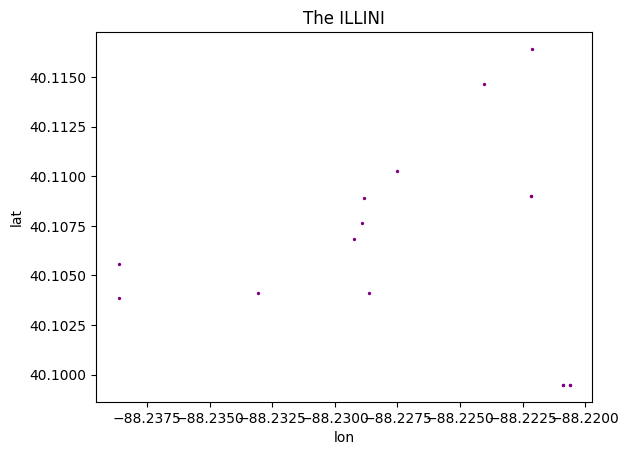

In [9]:
ILLINI_df.plot.scatter(x ="lon",y="lat",c="purple",title= "The ILLINI",s=2)

<Axes: title={'center': 'The Rest'}, xlabel='lon', ylabel='lat'>

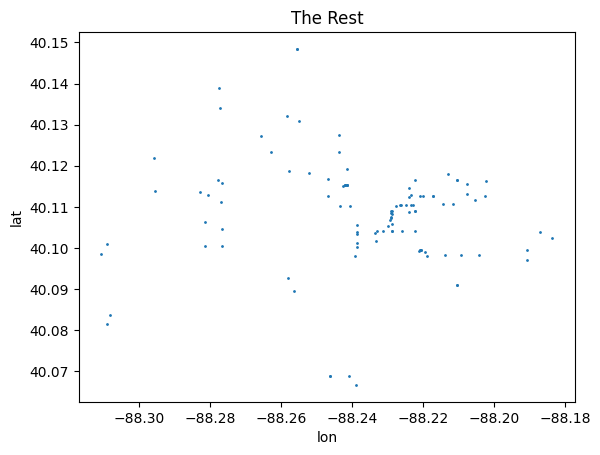

In [10]:
df.plot.scatter(x ="lon",y="lat",title= "The Rest",s=1)

Text(0, 0.5, 'lat')

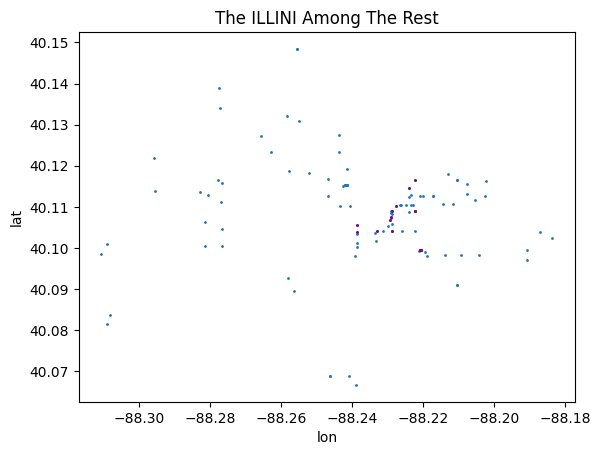

In [11]:
plt.scatter(x =df["lon"],y=df["lat"],s=1)
plt.scatter(x =ILLINI_df["lon"],y=ILLINI_df["lat"],s=1,c="purple")
plt.title("The ILLINI Among The Rest")
plt.xlabel("lon")
plt.ylabel("lat")

# Planning for Part II:

The early analysis done so far has been eye opening. While it may seem to the average ILLINI that the ILLINI is Perhaps the Most import bus in the MTD network, The above analysis has revealed that by more than one metric (stops, coverage... etc) the ILLINI is a small portion of MTDs service. 

While a decent amount of insight was gained in this notebook many questions remain un answered such as:
1. What are the Characteristics of the ILLINI?
    1. What does its speed profile look like?
    2. How reliable is it?
    3. does it behave differently in Different Sections of its route?
    4. ...
2. How does the ILLINI compare to other routes i the MTD system?
    1. Is it faster or slower than the average bus?
    2. does it cover more stops than the average bus?
    3. ...
3. How good is the Schedule of the ILLINI anyway?
    1. would it perhaps be more useful to run it a non-uniform schedule (more frequent at xx:45 then xx:15 perrhaps, to help people get to class?)
    2. ... 

The ILLINI is an enigma and more mysteries then mentioned above, I am sure, remain un-answered. 
Stay tuned for Project 2.2 to continue on this journey of discovery.


# Section 5: Data Science

The question I have choosen is: What are the characteristics of the Illini?

I plan on answering this question by:
1. Using the location and time data of the illini to calculate its speed in degrees of latitude/ longitude per minute.
2. Feeding this data into a KMeans model to see if the ILLINI Behaves differently inn different locations
3. visualizing a congestion map of the Illini route with this data

This should provide a clear picture of what the speed characteristic is of the Illini bus route

In [12]:
#a list of dataframes by bus
ILLINI_BUSes = [ILLINI_df[ILLINI_df["vehicle_id"] == id].reset_index(drop=True) for id in ILLINI_df.vehicle_id.unique()]
ILLINI_BUSes

[   vehicle_id               last_updated        previous_stop  \
 0        2364  2026-01-28T18:54:52-06:00        Transit Plaza   
 1        2364  2026-01-28T18:55:52-06:00  Wright and Chalmers   
 
              next_stop            origin_stop  \
 0   Fifth and Chalmers  Lincoln and Killarney   
 1  Fourth and Chalmers  Lincoln and Killarney   
 
                    destination_stop        lat       lon         route  age  
 0  Pennsylvania Ave. Residence Hall  40.107650 -88.22890  ILLINI SOUTH    3  
 1  Pennsylvania Ave. Residence Hall  40.106833 -88.22925  ILLINI SOUTH    3  ,
    vehicle_id               last_updated      previous_stop  \
 0        2429  2026-01-28T18:54:43-06:00      Campus Circle   
 1        2429  2026-01-28T18:55:49-06:00  Goodwin and Clark   
 
                       next_stop            origin_stop  \
 0              Goodwin and Main  Lincoln and Killarney   
 1  Goodwin at Ceramics Building  Lincoln and Killarney   
 
                    destination_stop 

In [13]:
# calculating speed and storing it in a column named dist (as in distance in degrees covered in the past minute)
for i2 in range(len(ILLINI_BUSes)):
    ILLINI_BUSes[i2]["dist"] = [0] + [(ILLINI_BUSes[i2]["lat"][i] - ILLINI_BUSes[i2]["lat"][i-1])**2 + (ILLINI_BUSes[i2]["lon"][i] - ILLINI_BUSes[i2]["lon"][i-1])**2 for i in range(1,len(ILLINI_BUSes[i2]["lat"]))]
ILLINI_BUSes

[   vehicle_id               last_updated        previous_stop  \
 0        2364  2026-01-28T18:54:52-06:00        Transit Plaza   
 1        2364  2026-01-28T18:55:52-06:00  Wright and Chalmers   
 
              next_stop            origin_stop  \
 0   Fifth and Chalmers  Lincoln and Killarney   
 1  Fourth and Chalmers  Lincoln and Killarney   
 
                    destination_stop        lat       lon         route  age  \
 0  Pennsylvania Ave. Residence Hall  40.107650 -88.22890  ILLINI SOUTH    3   
 1  Pennsylvania Ave. Residence Hall  40.106833 -88.22925  ILLINI SOUTH    3   
 
            dist  
 0  0.000000e+00  
 1  7.899890e-07  ,
    vehicle_id               last_updated      previous_stop  \
 0        2429  2026-01-28T18:54:43-06:00      Campus Circle   
 1        2429  2026-01-28T18:55:49-06:00  Goodwin and Clark   
 
                       next_stop            origin_stop  \
 0              Goodwin and Main  Lincoln and Killarney   
 1  Goodwin at Ceramics Building  Li

# Section 6: Diffenerent Visualizations

the following graphs will all shed light on the speed profile of the Illini in some way:
1. the first plot is a plot of the speeds of ILLINI bus 2367, as you will see it shows that the ILLINI is a very much stop and go bus that stops at more or less every stop, thus its speed profile graph is a relentless up and down cycle like a zig zag making it hit speed 0 regularly.
2. The second line graph is an elbow plot to help determine the numer of clusters The ILLINI should be classified into, the result was 3
3. The third grpah shows a visulaization of the clusters our kmeans model produced, It slipt the ILLINI into 3 distinct regions: 
    1. Ikenberry and Armory
    2. Central Campus and FAR/PAR
    3. Off Campus Northern stretch
4. The fourth graph and the fifith graph visualize the spped of the ILLINI by location with a scatter plot. each do is one bus at a particular location. both graphs show that main street like Wright Street and Goodwin street see slower ILLINI busses on them and the IllINI is fastest off campus
    1. In the fourth graph the dots are bigger if the bus was faster
    2. In the fifth graph the dots are bigger if the bus was slower 


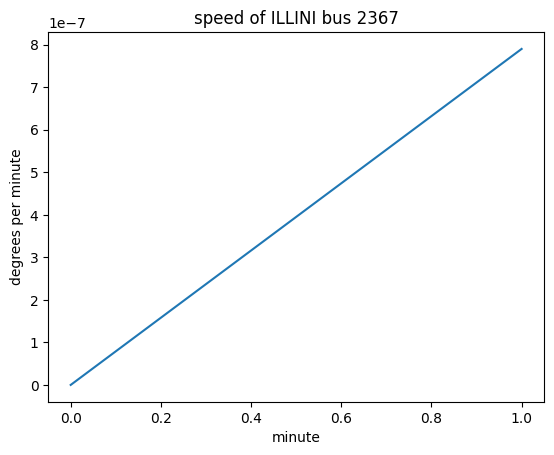

In [14]:
plt.title("speed of ILLINI bus 2367")
plt.ylabel("degrees per minute")
plt.xlabel("minute")
plt.plot(ILLINI_BUSes[0].dist)

In [15]:
#dumping some trash data (they werent 1 minute appart because i lost internet connection for a a bit when i started gathering bus data)
for i2 in range(len(ILLINI_BUSes)):
    ILLINI_BUSes[i2] = ILLINI_BUSes[i2][3:]

In [16]:
#converting list to one big dataframe
ILLINI_BUSes = pd.concat(ILLINI_BUSes)
ILLINI_BUSes

,vehicle_id,last_updated,previous_stop,next_stop,origin_stop,destination_stop,lat,lon,route,age,dist


In [17]:
# creating a dataframe with z scores for the kmeans model
ILLINI_BUSes_standardized = ILLINI_BUSes[["vehicle_id"]].copy()
ILLINI_BUSes_standardized["lat"] = (ILLINI_BUSes["lat"] - ILLINI_BUSes["lat"].mean())/ILLINI_BUSes["lat"].std() 
ILLINI_BUSes_standardized["lon"] = (ILLINI_BUSes["lon"] - ILLINI_BUSes["lon"].mean())/ILLINI_BUSes["lon"].std()
ILLINI_BUSes_standardized["dist"] = (ILLINI_BUSes["dist"] - ILLINI_BUSes["dist"].mean())/ILLINI_BUSes["dist"].std()
ILLINI_BUSes_standardized

,vehicle_id,lat,lon,dist


In [18]:
#determining the appropriate number of means to consider
ind = ["lat","lon","dist"]
def calculate_inertia(k):
    model = KMeans(k)
    model.fit(ILLINI_BUSes_standardized[ind])
    return model.inertia_

data = []
for i in range(8):
    k = i + 1 # add 1 since range(8) gives 0 through 7
    inertia = calculate_inertia(k)
    d = {"k": k, "inertia": inertia}
    data.append(d)
df_inertia = pd.DataFrame(data)
df_inertia

df_inertia.plot.line(x = "k", y = "inertia", title = "Elbow Plot")

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by KMeans.

In [ ]:
#just visually, 3 seemed resonable
kmeans = KMeans(3)
ILLINI_BUSes["Cluster"] = kmeans.fit(ILLINI_BUSes_standardized[ind]).predict(ILLINI_BUSes_standardized[ind])

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.14/lib/p

In [ ]:
#determining smallest non-zero dist for a coming visualization
ILLINI_BUSes = ILLINI_BUSes.reset_index(drop= True)
ILLINI_BUSes.nsmallest(110, "dist")

,vehicle_id,last_updated,previous_stop,next_stop,origin_stop,destination_stop,lat,lon,route,age,dist,Cluster
23,2367,2025-11-13T13:44:27-06:00,Fourth and Peabody,Gregory at Library,Lincoln and Killarney,Pennsylvania Ave. Residence Hall,40.103950,-88.233383,ILLINI South,2,0.000000e+00,0
38,2367,2025-11-13T13:59:33-06:00,Unknown,Pennsylvania and Maryland Dr.,Pennsylvania Ave. Residence Hall,Lincoln and Killarney,40.099467,-88.220883,ILLINI North,2,0.000000e+00,1
39,2367,2025-11-13T14:00:33-06:00,Unknown,Pennsylvania and Maryland Dr.,Pennsylvania Ave. Residence Hall,Lincoln and Killarney,40.099467,-88.220883,ILLINI North,2,0.000000e+00,1
40,2367,2025-11-13T14:01:33-06:00,Unknown,Pennsylvania and Maryland Dr.,Pennsylvania Ave. Residence Hall,Lincoln and Killarney,40.099467,-88.220883,ILLINI North,2,0.000000e+00,1
41,2367,2025-11-13T14:02:33-06:00,Unknown,Pennsylvania and Maryland Dr.,Pennsylvania Ave. Residence Hall,Lincoln and Killarney,40.099467,-88.220883,ILLINI North,2,0.000000e+00,1
...,...,...,...,...,...,...,...,...,...,...,...,...
956,2105,2025-11-13T13:22:54-06:00,Unknown,Wright and Chalmers,Transit Plaza,LAR,40.113200,-88.229017,ILLINI SOUTH,4,0.000000e+00,0
957,2105,2025-11-13T13:22:54-06:00,Unknown,Wright and Chalmers,Transit Plaza,LAR,40.113200,-88.229017,ILLINI SOUTH,4,0.000000e+00,0
958,2105,2025-11-13T13:22:54-06:00,Unknown,Wright and Chalmers,Transit Plaza,LAR,40.113200,-88.229017,ILLINI SOUTH,4,0.000000e+00,0
959,2105,2025-11-13T13:22:54-06:00,Unknown,Wright and Chalmers,Transit Plaza,LAR,40.113200,-88.229017,ILLINI SOUTH,4,0.000000e+00,0


Text(0.5, 1.0, '3 cluster plot')

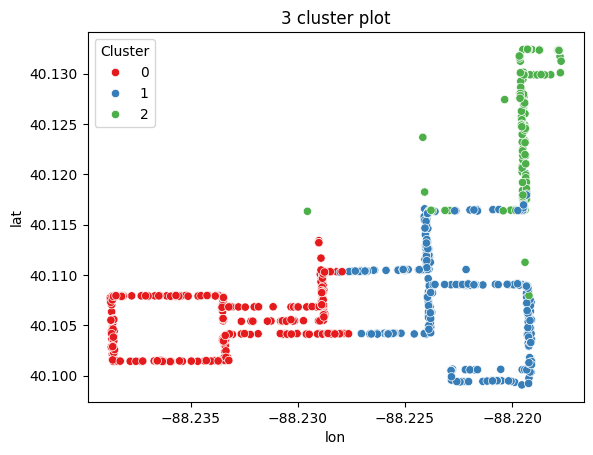

In [ ]:
sns.scatterplot(
    data = ILLINI_BUSes,
    x = "lon",
    y = "lat",
    hue = ILLINI_BUSes["Cluster"],
    palette = "Set1",
)
plt.title("3 cluster plot")

Text(0.5, 1.0, '3 cluster plot Speed visualization')

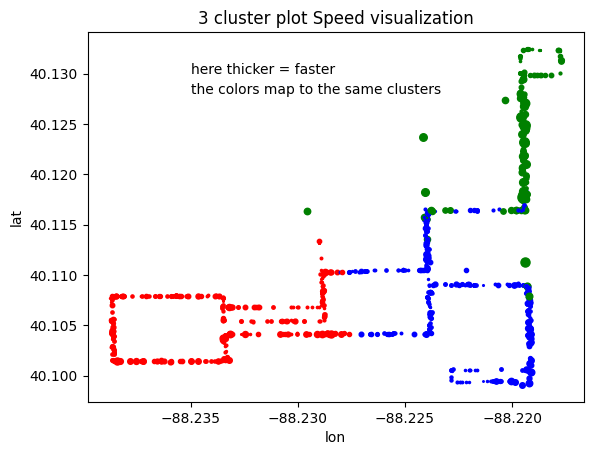

In [ ]:
d = {0: "r", 1: "b", 2: "g"}
for i in range(len(ILLINI_BUSes)): 
    plt.scatter(
        x = ILLINI_BUSes["lon"][i],
        y = ILLINI_BUSes["lat"][i],
        c = d[ILLINI_BUSes["Cluster"][i]],
        s = ILLINI_BUSes["dist"][i]*1000000 + 1
    )
plt.xlabel("lon")
plt.ylabel("lat")
plt.text(s = "here thicker = faster", y = 40.130, x = -88.235)
plt.text(s = "the colors map to the same clusters", y = 40.128, x = -88.235)
plt.title("3 cluster plot Speed visualization")

Text(0.5, 1.0, '3 cluster plot Congestion Visualization')

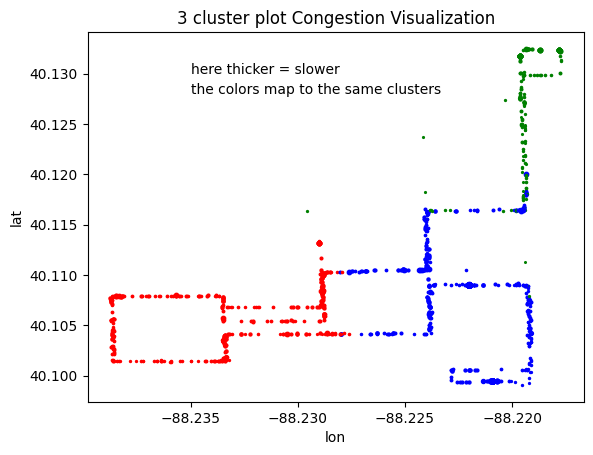

In [ ]:
# congestion map
for i in range(len(ILLINI_BUSes)):
    plt.scatter(
        x = ILLINI_BUSes["lon"][i],
        y = ILLINI_BUSes["lat"][i],
        c = d[int(ILLINI_BUSes["Cluster"][i])],
        s = ((ILLINI_BUSes["dist"]**(-1/3)*0.05)[i] if (ILLINI_BUSes["dist"]**(-1/3)*0.05)[i] < 10 else 10)
    )
plt.xlabel("lon")
plt.ylabel("lat")
plt.text(s = "here thicker = slower", y = 40.130, x = -88.235)
plt.text(s = "the colors map to the same clusters", y = 40.128, x = -88.235)
plt.title("3 cluster plot Congestion Visualization")

In [ ]:
ILLINI_BUSes[ILLINI_BUSes.Cluster == 0].dist.mean()

np.float64(5.354351345456332e-06)

In [ ]:
ILLINI_BUSes[ILLINI_BUSes.Cluster == 1].dist.mean()

np.float64(4.2923314008905475e-06)

In [ ]:
ILLINI_BUSes[ILLINI_BUSes.Cluster == 2].dist.mean()

np.float64(1.2400096769231247e-05)

# Summary 

This project collected real-time bus data using the Champaign-Urbana Mass Transit District’s (MTD) open API to answer one central question: Can machine learning be used to improve the ILLINI bus route? The dataset included bus speed over time, geographic location, and other individual bus identifiers.

When SciPy’s KMeans clustering algorithm was applied to the data, the ILLINI route naturally divided into three distinct sections: Ikenberry, Campus Center, and Off-Campus. Analysis of these regions showed that buses operating in the off-campus area travel at a significantly higher speed—nearly a full order of magnitude faster—averaging 12.4 micro-degrees per minute, compared to 6.2 and 4.0 micro-degrees per minute on campus. This represents a meaningful difference in operational patterns across the route; however, further research is required to determine the root cause of this discrepancy. If the factors responsible for the higher off-campus speeds—such as traffic conditions or stop frequency—are implementable on campus, this project would recommend applying similar strategies to improve on-campus bus efficiency.